In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os,sys
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import math
%matplotlib inline

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

## edge detection
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color 
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def draw_extended_lines(img, lines, color=[255, 0, 0], thickness=4):
    """
    Draw extended lines with segments generated by Hough Transformation. This strategy consists four steps:
    1. approximate the slope of the lane line
    2. approximate the center point of lane line
    3. approximate the bias of the lane line
    4. determine the top/bottom points of lane line through two interception lines
    
    This method need to be impoved in the near future, since still has some flickery in video.
    """
    pos_k = []
    neg_k = []
    pos_center = [0, 0]
    neg_center = [0, 0]
    for line in lines:
        for x1, y1, x2, y2 in line:
            k = (y2 - y1)/(x2 - x1)
            if(k >= 0):
                pos_k.append(k)
                pos_center[0] += (x1 + x2)/2
                pos_center[1] += (y1 + y2)/2
            else:
                neg_k.append(k)
                neg_center[0] += (x1 + x2)/2
                neg_center[1] += (y1 + y2)/2
    if(len(pos_k) > 0):
        ## approximate the slope(gradient) of lane line
        k1 = np.mean(pos_k)
        ## approximate the center point of lane line
        pos_center[0] /= len(pos_k)
        pos_center[1] /= len(pos_k)
        ## approximate the bias of lane line
        b1 = pos_center[1] - k1 * pos_center[0]
        ## interception with two line, get the top/bottom points of lane line
        pos_top = [0, img.shape[0]]
        pos_bottom = [0, 325]
        pos_top[0] = int((pos_top[1] - b1)/k1)
        pos_bottom[0] = int((pos_bottom[1] - b1)/k1)
        ## draw
        cv2.line(img, (pos_bottom[0], pos_bottom[1]), (pos_top[0], pos_top[1]), color, thickness)
 
    if(len(neg_k) > 0):
        ## approximate the slope(gradient) of lane line
        k2 = np.mean(neg_k)
        ## approximate the center point of lane line
        neg_center[0] /= len(neg_k)
        neg_center[1] /= len(neg_k)
        ## approximate the bias of lane line
        b2 = neg_center[1] - k2 * neg_center[0]
        ## interception with two line, get the top/bottom points of lane line
        neg_top = [0, img.shape[0]]
        neg_bottom = [0, 325]
        neg_top[0] = int((neg_top[1] - b2)/k2)
        neg_bottom[0] = int((neg_bottom[1] - b2)/k2)
        ## draw
        cv2.line(img, (neg_bottom[0], neg_bottom[1]), (neg_top[0], neg_top[1]), color, thickness)
        
def hough_lines(extended, img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if(extended == False):
        draw_lines(line_img, lines)
    else:
        draw_extended_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [3]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [4]:
## Test on Images

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


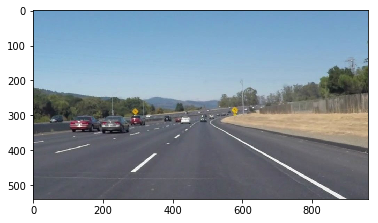

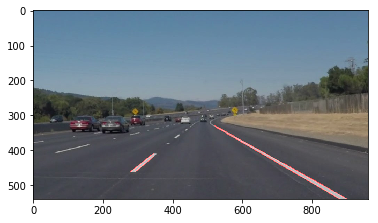

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


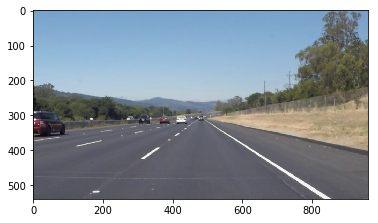

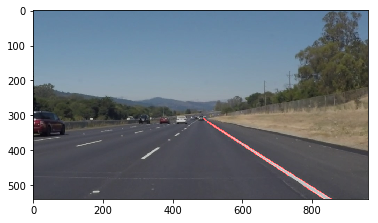

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


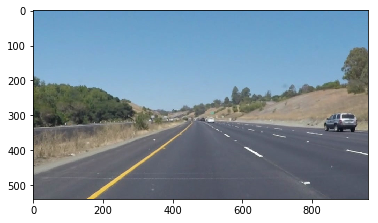

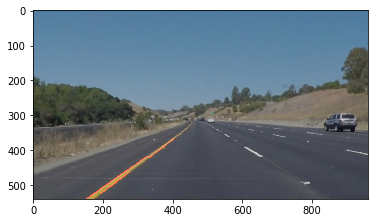

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


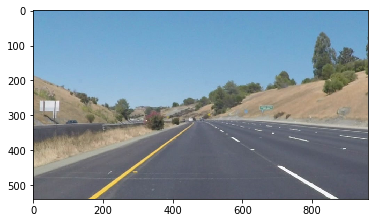

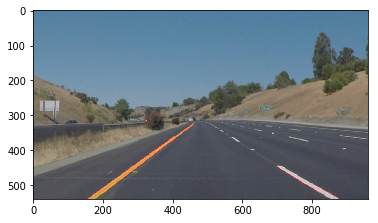

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


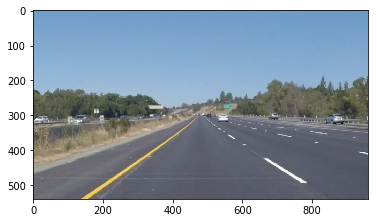

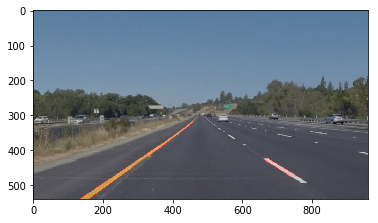

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


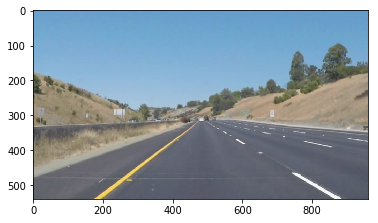

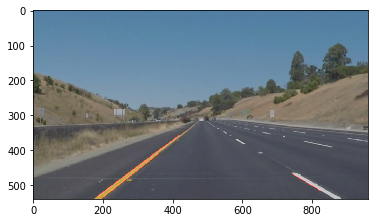

In [5]:
def process_image(extended, origin_image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    ## grayscale
    grayimg = grayscale(origin_image)

    ## edge detection
    input_img = grayimg
    blurimg = gaussian_blur(input_img, 5)
    cannyimg = canny(input_img, 100, 220)

    ## roi
    input_img = cannyimg
    vertices = np.array([[(0, input_img.shape[0]), (input_img.shape[1], input_img.shape[0]), ((input_img.shape[1]/2), 300)]], dtype= np.int32)
    roiimage = region_of_interest(input_img, vertices)

    ## hough transform
    input_img = roiimage
    rho= 2
    theta= 1 * np.pi/180
    threshold= 5
    min_line_len= 50
    max_line_gap= 3
    houghimg = hough_lines(extended, input_img, rho, theta, threshold, min_line_len, max_line_gap)
    ognimg = np.copy(origin_image)
    wightedimg = weighted_img(houghimg, ognimg)

    return wightedimg

OutputDir = 'test_images_output/'
if(os.path.exists(OutputDir) == False):
    os.makedirs(OutputDir)
for img in os.listdir("test_images/"):
    #reading in an image
    origin_image = mpimg.imread('test_images/%s' % img)

    #printing out some stats and plotting
    print('This image is:', type(origin_image), 'with dimensions:', origin_image.shape)
    plt.imshow(origin_image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
    plt.show()

    resultimg = process_image(False, origin_image)
    
    plt.imshow(resultimg, cmap='Greys_r')
    plt.show()
    # save
    plt.imsave('%s/%s' % (OutputDir, img), resultimg)

In [6]:
## Test on Videos

In [7]:
InputDir = 'test_videos'
OutputDir = 'test_videos_output'
if(os.path.exists(OutputDir) == False):
    os.makedirs(OutputDir)
for video in os.listdir("test_videos/"):
    if(video == 'challenge.mp4'):
        continue
    #reading in an video
    white_output = '%s/%s' % (OutputDir, video)
    clip1 = VideoFileClip("%s/%s" % (InputDir, video))#.subclip(0, 5)
    white_clip = clip1.fl_image(lambda x: process_image(True, x)) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:02<00:00, 101.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 1.73 s, sys: 246 ms, total: 1.98 s
Wall time: 2.54 s
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:07<00:00, 96.34it/s] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 5.55 s, sys: 669 ms, total: 6.22 s
Wall time: 7.49 s
